In [1]:
setwd("C:/Users/User/Documents")
source("Meus Arquivos/Códigos/Funções.R")

In [2]:
pacotes <- c("reticulate","tidyverse",
             "tidyquant","fANCOVA","bizdays",
             "PerformanceAnalytics","KernSmooth","rmgarch")
for(i in pacotes){
  suppressPackageStartupMessages(library(i, character.only = T))
}
options(warn = -1)

Warning message:
"package 'fANCOVA' was built under R version 4.0.3"
Warning message:
"package 'KernSmooth' was built under R version 4.0.3"


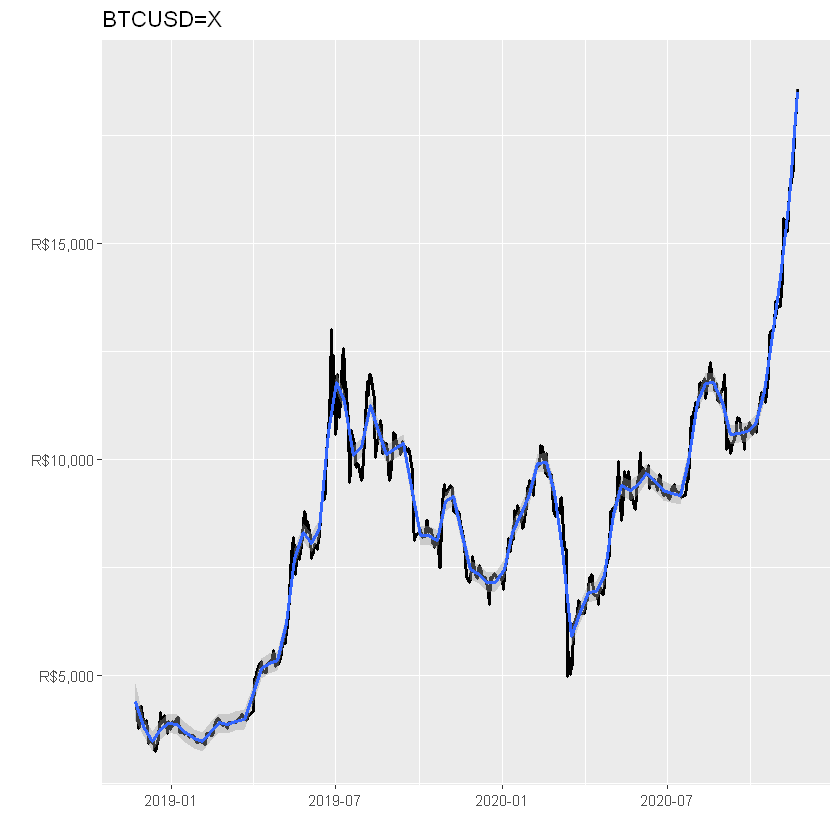

In [3]:
acao <- "BTCUSD=X"
data <- adjust.next(Sys.Date()-365*2, "Brazil/ANBIMA")
itub <- na.omit(tq_get(acao, from = data))
fit <- loess.as(itub$date, itub$adjusted, user.span = NULL, plot = F)
suavizar <- fit$pars$span
ggplot(itub, aes(x = date, y = adjusted))+
  geom_line(size =1)+
  geom_smooth(formula = y ~ x, method = "loess", span = suavizar)+
  scale_y_continuous(labels = scales::dollar_format(prefix = "R$"))+
  labs(x = "", y = "", title = acao)

In [4]:
##Loess
a <- loess(adjusted ~ as.numeric(date), data = itub, na.action = na.omit,
           span = suavizar)
#Ksmoothing
band <- dpill(time(itub$adjusted), itub$adjusted)
b <- ksmooth(time(itub$adjusted), itub$adjusted,"norm", bandwidth = band)

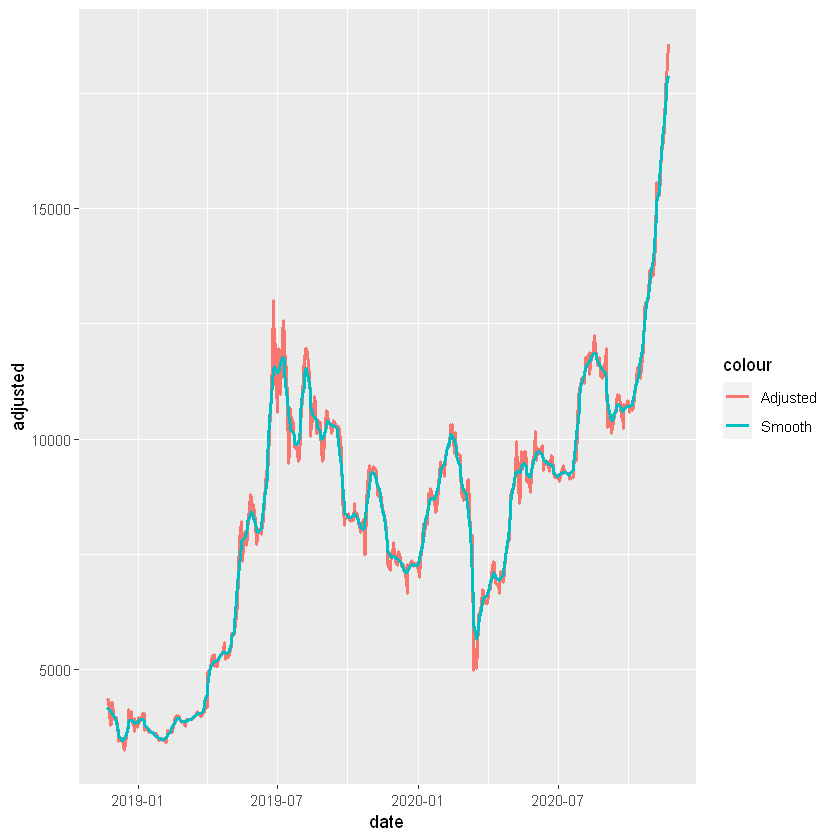

In [5]:
data <- data.frame(date = itub$date, adjusted = itub$adjusted, y = b$y)
ggplot(data, aes(x = date))+
  geom_line(aes(y = adjusted, col = "Adjusted"), size = 1)+
  geom_line(aes(y = y, col = "Smooth"), size = 1)

In [6]:
#Criando o data.frame
a_t <- data.frame(date = itub$date,y = a$fitted)
a_t$dif <- c(0,diff(a_t$y)/a_t$y[2:nrow(a_t)-1])
a_t$sell_buy <- NA
a_t$dif_r <- c(0, diff(itub$adjusted)/itub$adjusted[2:nrow(itub)-1])

In [7]:
spec <- ugarchspec(variance.model = list("eGARCH"),
                   mean.model = list(armaOrder = c(0,0)),
                   distribution.model = "std")
a_t$vol_ativo <- ugarchfit(spec,a_t$dif_r)@fit$sigma

In [8]:
#Estabelecendo os cenários
moderado <- quantile(a_t$dif_r, prob = 0.8) #Retorno moderado
for(i in 2:nrow(a_t)){
  if(a_t$dif[i] > 0 & a_t$dif[i] <= moderado){
    a_t$sell_buy[i] <- "Moderate Buy"
  }else if(a_t$dif[i] > moderado){
    a_t$sell_buy[i] <- "Strong Buy"
  }else if(a_t$dif[i] <= 0 & a_t$dif[i] >= -moderado){
    a_t$sell_buy[i] <- "Moderate Sell"
  }else{
    a_t$sell_buy[i] <- "Strong Sell"
  }
}

In [9]:
#Dados da simulação
tx_l <- 0.02 #Taxa livre de risco
a_t1 <- na.omit(a_t)
n <- numeric(nrow(a_t1))
valor_m <- 0.3 #% da carteira para comprar ou vender em moderado
valor_M <- 0.5 #% da carteira para comprar ou vender em forte
for(i in 2:nrow(a_t1)){
  if(a_t1$sell_buy[i-1] == "Moderate Sell"){
    n[i] <- -valor_m*a_t1$dif_r[i]+(1+valor_m)*((1+tx_l)^(1/252)-1)
  }else if(a_t1$sell_buy[i-1] == "Strong Sell"){
    n[i] <- -valor_M*a_t1$dif_r[i]+(1+valor_M)*((1+tx_l)^(1/252)-1)
  }else if(a_t1$sell_buy[i-1] == "Moderate Buy"){
    n[i] <- valor_m*a_t1$dif_r[i]+(1-valor_m)*((1+tx_l)^(1/252)-1)
  }else{
    n[i] <- valor_M*a_t1$dif_r[i]+(1-valor_M)*((1+tx_l)^(1/252)-1)
  }
}
a_t1$ret <- n
a_t1$vol_ret <- ugarchfit(spec, a_t1$ret)@fit$sigma
a_t1$resultado <- cumprod(n+1)
a_t1$ativo <- cumprod(c(0,a_t1$dif_r[2:nrow(a_t1)])+1)

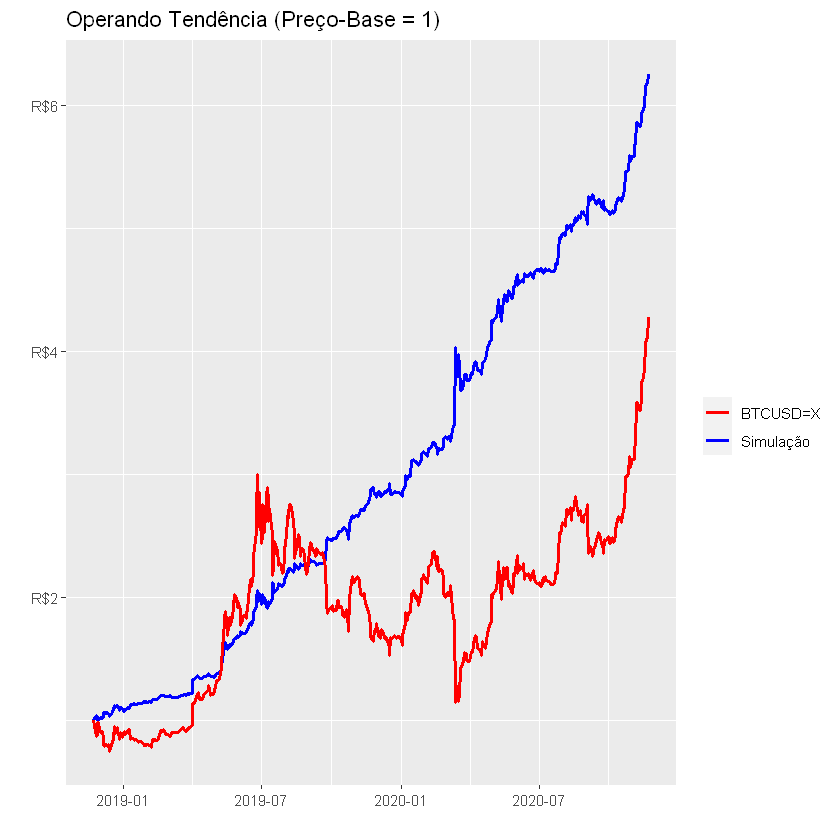

In [10]:
#Plot
ggplot(a_t1, aes(x = date))+
  geom_line(aes(y = resultado, col = "Simulação"), size = 1)+
  geom_line(aes(y = ativo, col = acao), size = 1)+
  labs(x = "", y = "", title = "Operando Tendência (Preço-Base = 1)")+
  scale_y_continuous(labels = scales::dollar_format(prefix = "R$"))+
  scale_color_manual("", values = c("red","Simulação" = "blue"))

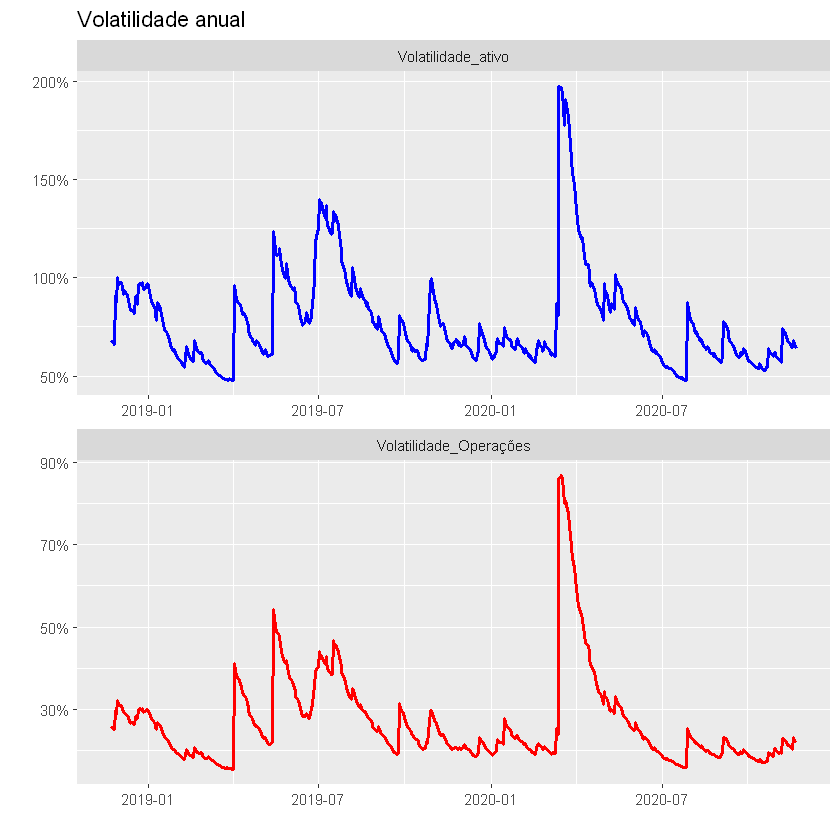

In [11]:
a_t1 %>%
  rename(Volatilidade_ativo = vol_ativo, Volatilidade_Operações = vol_ret) %>%
  gather(key = "vol", value = "sigma", -c(date, y, dif, dif_r, ret,
                                          sell_buy, resultado, ativo)) %>%
  ggplot(aes(x = date, y = sigma*sqrt(252), col = vol))+
  geom_line(size = 1)+
  scale_y_continuous(labels = scales::percent)+
  labs(x = "", y = "", title = "Volatilidade anual")+
  facet_wrap(~vol, nrow = 2, scales = "free")+
  scale_color_manual("", values = c("Volatilidade_ativo" = "blue","Volatilidade_Operações" = "red"))+
  theme(legend.position = "none")

In [12]:
#Últimos dias
xts::last(a_t1,5)

,date,y,dif,sell_buy,dif_r,vol_ativo,ret,vol_ret,resultado,ativo
,<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
518,2020-11-16,17111.61,0.04617958,Strong Buy,0.0244087671,0.04112182,0.007377640,0.01302874,5.986771,3.845340
519,2020-11-17,17377.30,0.01552667,Moderate Buy,0.0555919320,0.04057080,0.027835258,0.01284068,6.153415,4.059110
520,2020-11-18,17650.12,0.01569968,Moderate Buy,0.0089892637,0.04276035,0.002751789,0.01458952,6.170347,4.095599
521,2020-11-19,17930.03,0.01585900,Moderate Buy,0.0007340119,0.04156066,0.000275213,0.01420922,6.172046,4.098605
522,2020-11-21,18511.00,0.03240185,Strong Buy,0.0424671367,0.04038411,0.012795150,0.01385067,6.251018,4.272661


In [13]:
#Períodos de forte volatilidade
a_t1[grepl("Strong",a_t1$sell_buy),]

,date,y,dif,sell_buy,dif_r,vol_ativo,ret,vol_ret,resultado,ativo
,<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,2018-11-26,4120.805,-0.04700367,Strong Sell,-0.1306570310,0.04153827,3.929927e-02,0.015779319,1.039299,0.8693430
8,2018-12-03,3730.928,-0.03865523,Strong Sell,-0.0306517372,0.06145959,9.297682e-03,0.019571437,1.024784,0.8957978
18,2018-12-17,3617.785,0.03202352,Strong Buy,0.0935639479,0.05151424,2.812419e-02,0.016536964,1.061489,0.8156831
93,2019-04-01,4565.817,0.06455290,Strong Buy,0.0145931303,0.03017185,4.432949e-03,0.009790318,1.221585,0.9565395
98,2019-04-08,5085.325,0.04387458,Strong Buy,0.0502491244,0.05448728,1.512975e-02,0.023346307,1.360943,1.2168478
118,2019-05-06,6014.540,0.07180167,Strong Buy,-0.0037246499,0.03989883,-1.062386e-03,0.014546107,1.377607,1.3219831
121,2019-05-09,6482.931,0.02912046,Strong Buy,0.0321056716,0.03789150,9.686711e-03,0.013688208,1.412119,1.4203754
122,2019-05-10,6682.997,0.03086041,Strong Buy,0.0330909191,0.03811915,1.658475e-02,0.013552034,1.435538,1.4673769
123,2019-05-13,7223.347,0.08085439,Strong Buy,0.2251297890,0.03839825,1.126042e-01,0.013892915,1.597186,1.7977272


In [14]:
#Média de acertos
mean(a_t1$ret > 0)

[1] 0.6084453

In [15]:
table(a_t1$sell_buy)


 Moderate Buy Moderate Sell    Strong Buy   Strong Sell 
          271           201            31            18 

In [16]:
reto <- xts(a_t1$ret, a_t1$date)
colnames(reto) <- "Simulação"

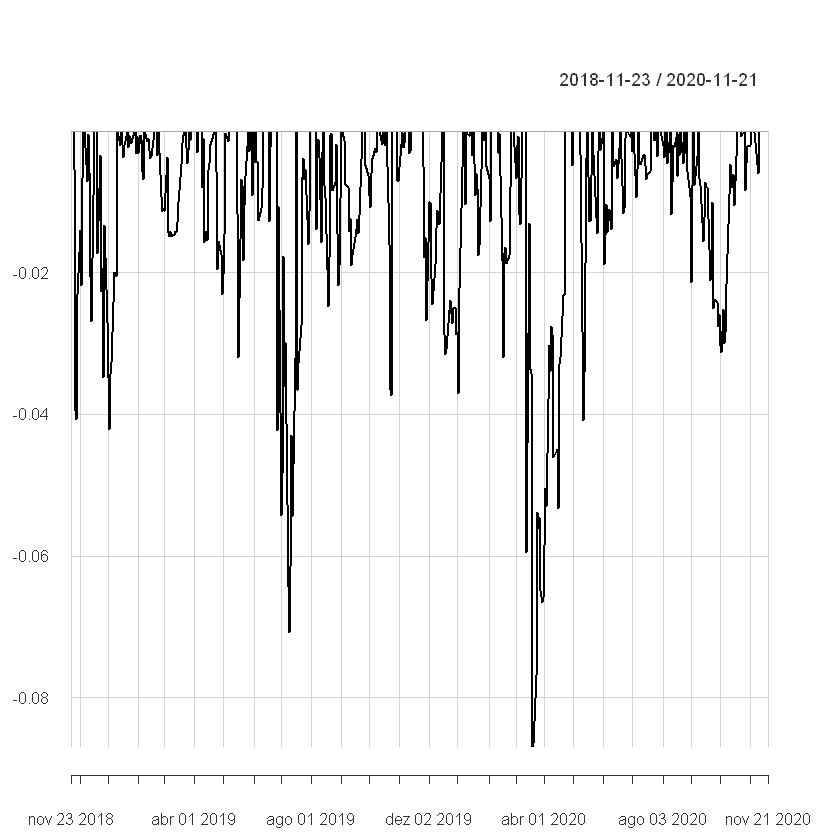

In [17]:
chart.Drawdown(reto)

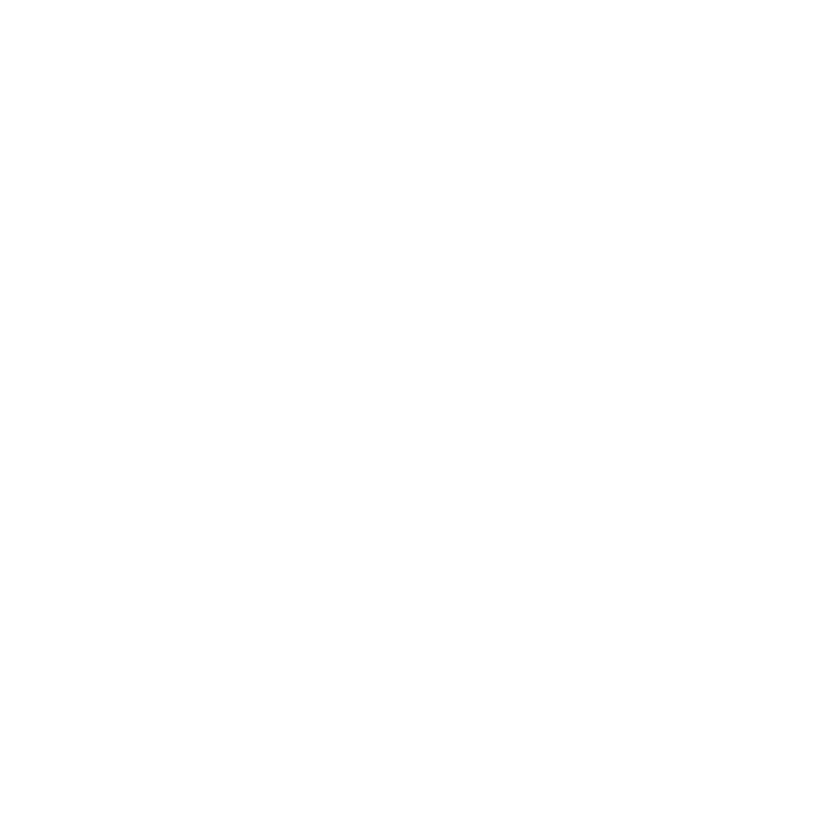

In [24]:
#VaR
try(suppressMessages(chart.VaRSensitivity(reto)),silent = T)

In [25]:
#Sharpe
media <- mean(reto)*252
sd_r <- sd(reto)*sqrt(252)
sharpe <- (media-tx_l)/sd_r
names(sharpe) <- "Sharpe"
print(sharpe,4)

Sharpe 
 3.514 


In [26]:
#Beta
beta <- cov(a_t1$ret, a_t1$dif_r)/var(a_t1$dif_r)
names(beta) <- "Beta"
print(beta,4)

    Beta 
0.007371 


In [27]:
#Alpha
media_ativo <- mean(a_t1$dif_r)*252
alfa <- (media-tx_l)-beta*(media_ativo-tx_l)
paste0("Alpha = ",round(alfa*100,4),"%")

[1] "Alpha = 89.2582%"

In [28]:
#Tracking error
tr <- sqrt(sum((a_t1$ret-a_t1$dif_r)^2))/(nrow(a_t1)-1)
paste0("Tracking error = ",round(tr*100,3),"%")

[1] "Tracking error = 0.205%"

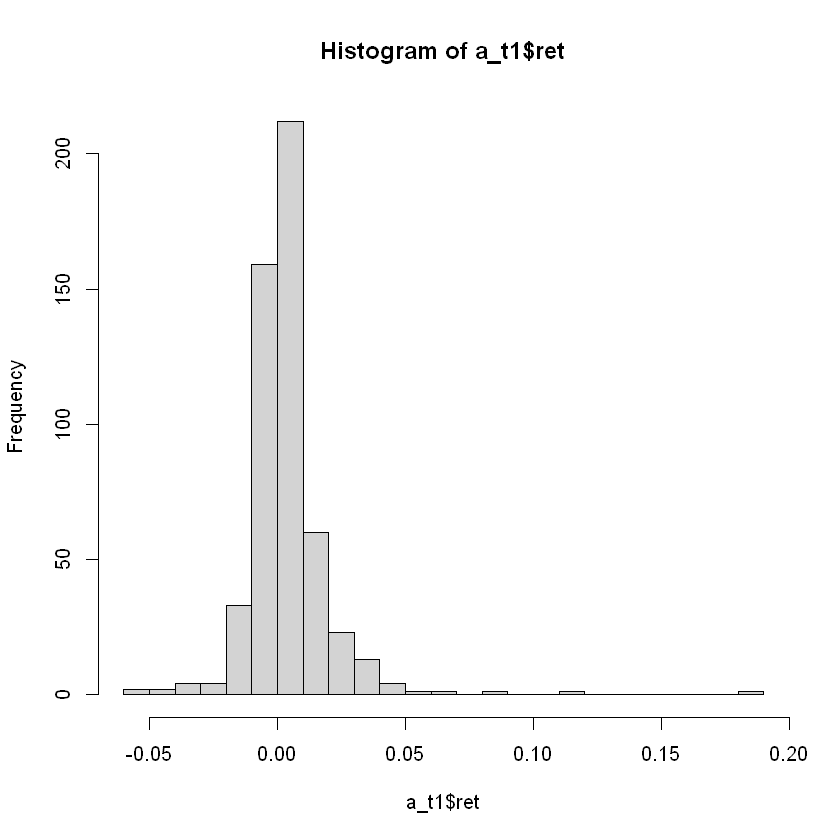

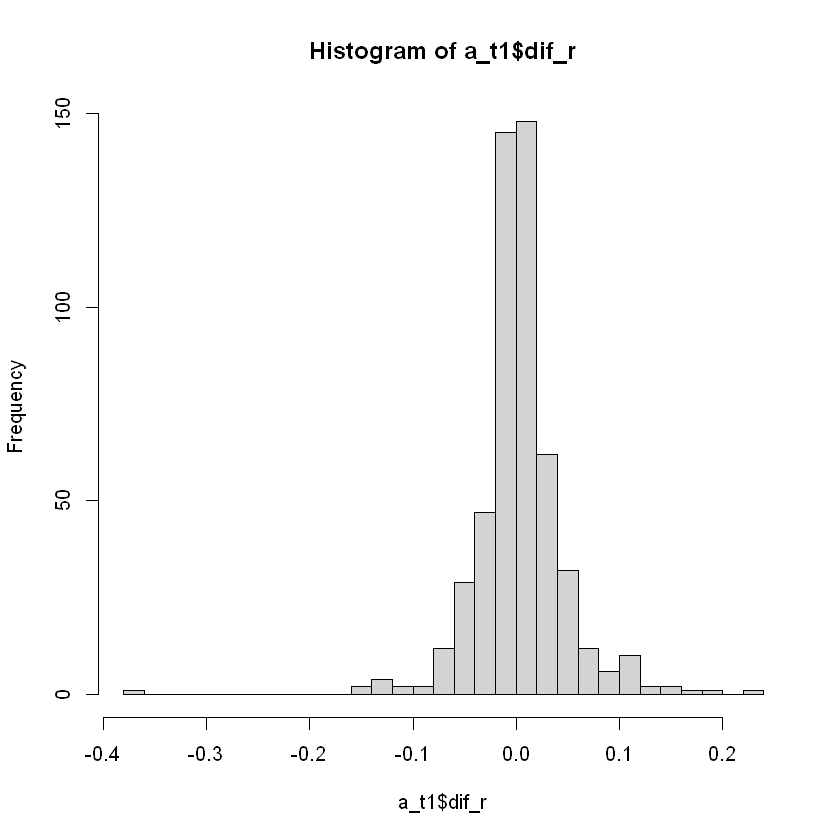

In [29]:
hist(a_t1$ret, breaks = 30, frequency = F)
hist(a_t1$dif_r, breaks = 30, frequency = F)